In [1]:
!pip install  tensorflow==2.15

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

print("Tensorflow version: ", tf.__version__)
print("Tensorflow Hub version: ", hub.__version__)

Tensorflow version:  2.15.0
Tensorflow Hub version:  0.16.1


In [3]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [4]:
model_all_images = load_model('drive/MyDrive/Colab Notebooks/unstructured-data-project/data/models/20250220-21591740088773-all-images-Adam.keras')

Loading saved model from: drive/MyDrive/Colab Notebooks/unstructured-data-project/data/models/20250220-21591740088773-all-images-Adam.keras


In [31]:
IMG_SIZE = 224

def process_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [28]:
BATCH_SIZE = 32

def create_data_batches(x, batch_size=BATCH_SIZE):
  print("Creating data batches...")
  data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
  data_batch = data.map(process_image).batch(batch_size)
  return data_batch

In [42]:
import os

random_dog_images_path = "drive/MyDrive/Colab Notebooks/unstructured-data-project/random-dog-images/"
random_dog_images_filenames = [random_dog_images_path + fname for fname in os.listdir(random_dog_images_path)]
random_dog_images_filenames

['drive/MyDrive/Colab Notebooks/unstructured-data-project/random-dog-images/dog-1.jpg',
 'drive/MyDrive/Colab Notebooks/unstructured-data-project/random-dog-images/dog-2.jpg',
 'drive/MyDrive/Colab Notebooks/unstructured-data-project/random-dog-images/dog-4.jpg',
 'drive/MyDrive/Colab Notebooks/unstructured-data-project/random-dog-images/dog-3.jpg']

In [43]:
random_dog_images_data = create_data_batches(random_dog_images_filenames)

Creating data batches...


In [45]:
image_preds = model_all_images.predict(random_dog_images_data, verbose=1)

1/1 [==============================] - 0s 456ms/step


### Visualize prediction

In [47]:
labels_csv = pd.read_csv("drive/MyDrive/Colab Notebooks/unstructured-data-project/data/labels.csv")
labels = labels_csv["breed"].to_numpy()

In [48]:
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [49]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [50]:
image_pred_labels = [get_pred_label(image_preds[i]) for i in range(len(image_preds))]
image_pred_labels

['basset', 'golden_retriever', 'kelpie', 'border_collie']

In [52]:
images = []

for image in random_dog_images_data.unbatch().as_numpy_iterator():
  images.append(image)

In [60]:
def plot_pred_conf(prediction_probabilities, n=0):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob = prediction_probabilities[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

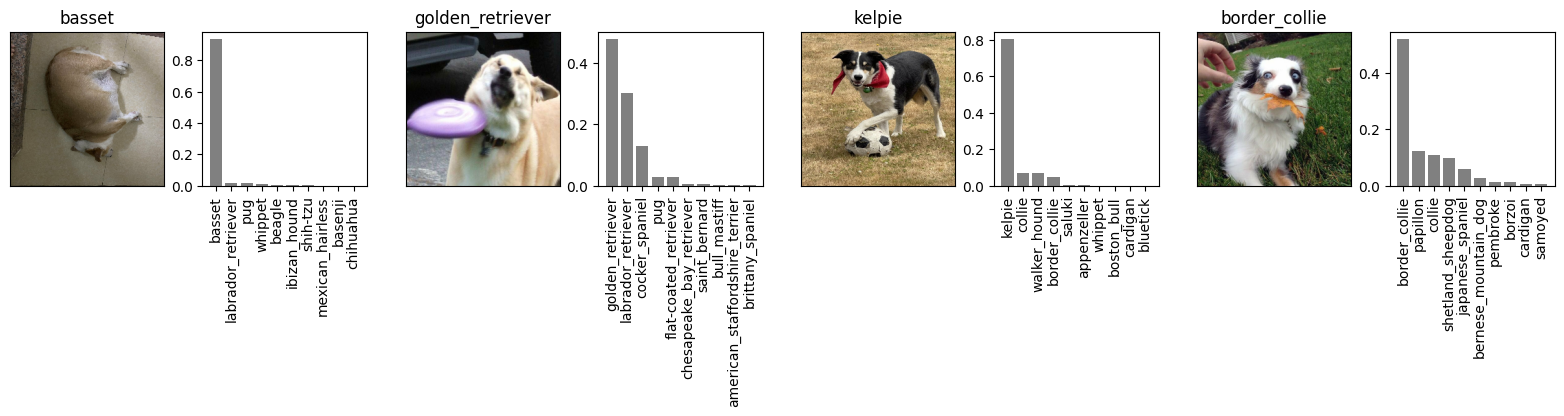

In [77]:
plt.figure(figsize=(20, 2))

for i, image in enumerate(images):
  plt.subplot(1, 8, 2*i+1)
  plt.title(image_pred_labels[i])
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  plt.subplot(1, 8, 2*i+2)
  plot_pred_conf(prediction_probabilities=image_preds, n=i)

plt.show()